## Perceptron

The perceptron is an algorithm for learning a *binary classifier*, it's function maps the input $x$ into an output value $f(x)$ which is binary. Perceptrons are inspired by the information processing of a single neural cell called a neuron. A neuron accepts input signals via it's dendrites, which pass an electrical signal down to the cell body. In a similar way, the Perceptron receives input signals from examples of training data that we weight and combined in a linear equation called the **activation**:

    activation = sum(weight_i * x_i) + bias

The activation is then transformed into an output value or prediction using a transfer function, such as the step transfer function:

    prediction = 1.0 if activation >= 0.0 else 0.0
    
In this way, the Perceptron is a classification algorithm for problems with two classes (0 and 1) where a linear equation (like or hyperplane) can be used to separate the two classes.

It is closely related to linear regression and logistic regression that make predictions in a similar way (e.g. a weighted sum of inputs).

The weights of the Perceptron algorithm must be estimated from your training data using stochastic **gradient descent**. This involves minimizing a function by following the gradients of the cost function:

$$
J_p(\theta)=\frac{1}{n}\sum_{i=1}^{n} \max(0, -y^{(i)} x^{(i)} \theta)
$$

where the maximized value is 0 if the prediction is correct, otherwise it is the confidence in the misprediction. For the Perceptron algorithm, each iteration the weights $w$ are updated using the equation:

    w = w + learning_rate * (expected - predicted) * x
    
where $w$ is the weight being optimized, $(expected - predicted)$ is the prediction error for the model on the training data attributed to the weight and $x$ is input.

### Sonar Dataset

We will demonstrate the Perceptron using the sonar dataset; it consists of 60 input columns which indicate the strength of returns at different angles (in radians). The final column contains a string "M" for mine and "R" for rock; this is our binary label we wish to classify. Most of the input values are around 0 to 1 so we don't need to consider *normalization* strategies.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

dataset = np.asarray(pd.read_csv("sonar-all-data.csv", header=None))

# convert labels into [0,1]
np.place(dataset[:,-1], dataset[:,-1]=='R', 0)
np.place(dataset[:,-1], dataset[:,-1]=='M', 1)
dataset = dataset.astype(np.float64)
X = dataset[:,:-1]
y = dataset[:,-1]

### Predicting States

Firstly we write down a prediction function which acts as our *linear model*, so for this dataset is:

    activation = (w_1 * X_1) + (w_2 * X_2) + bias

Here NumPy looks at the dimensions of $X$ and $w$, and figures out that the multiplication means I wish to multiply *every row* by $w$, and then summing every row. This is the equivalent of doing a *Matrix-Vector dot product*.

In [11]:
def predict_new(X, w):
    """
    Given input matrix X(n,p) and the w(p+1,), predicts (n,) labels for each sample i \in n.
    
    Bias term included as first weight, w[0]; remove.
    """
    # activation function
    yp = np.dot(X,w[1:]) + w[0]
    if type(yp) == np.float64:
        return 1. if yp >= 0. else 0.
    # replace activations >= 0 with 1, else replace with 0 - becoming yp predictions
    np.place(yp, yp >= 0., 1.)
    np.place(yp, yp < 0., 0.)
    return yp

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.] 
 [ True  True  True  True  True  True  True  True  True  True]


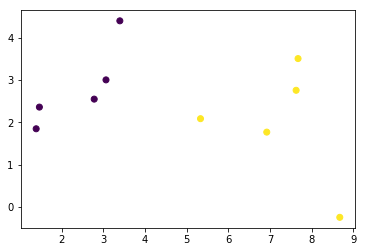

In [12]:
toy_dataset = np.array([[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]])

toy_weights = np.array([-0.1, 0.20653640140000007, -0.23418117710000003])

yp = predict_new(toy_dataset[:,:-1], toy_weights)

print("{} \n {} \n {}".format(toy_dataset[:,-1], yp, toy_dataset[:,-1]==yp))

plt.scatter(toy_dataset[:,0], toy_dataset[:,1], c=toy_dataset[:,-1])
plt.show()

### Training the Weights

Training the network weights can be achieved through *gradient descent*. This requires two parameters:
- **Learning rate** (eta): Used to limit the amount each weight is corrected each iteration
- **Epoch**: the number of times to run the training data weight updates

Weights are updated based on the error (loss) the model made. The error is calculated as the difference between expected output and the prediction made with the candidate weights.

There is one weight for each input column, and these are updated consistently:

    w(t+1) = w(t) + eta * (expected(t) - predicted(t)) * x(t)
    
The bias is updated in a similar way, except it is not associated to input:

    b(t+1) = b(t) + eta * (expected(t) - predicted(t))

In [13]:
def train_weights_new(X, y, eta, n_epochs, printing=True):
    """
    Given X(n,p), y(n,) true labels, learning rate and n_epoch, calculate best weights w(p+1,)
    
    Bias term is w[0].
    """
    # generate random weights
    w = np.zeros(X.shape[1]+1)
    # w[0] = intercept
    for epoch in range(n_epochs):
        sum_err = 0.
        # iterate over all rows
        for i in range(X.shape[0]):
            # calculate the predicted values using our predict method
            yp = predict_new(X[i,:],w)
            # compare predicted to actual
            error = y[i] - yp
            #error = y - yp
            sum_err += error**2
            # update bias term
            w[0] += eta * error
            # update weights - here error(n,) * X(n,p) will cause feature to be multiplied by the sample from error
            w[1:] += eta * error * X[i,:]
        #print(error.shape, X.shape, (eta * error[i] * X[i,:]).shape)
        if printing:
            print(">epoch=%d, eta=%.3f, error=%.3f" % (epoch, eta, sum_err))
    return w

In [14]:
new_w = train_weights_new(toy_dataset[:,:-1], toy_dataset[:,-1], 0.1, 5)
print(new_w)

>epoch=0, eta=0.100, error=2.000
>epoch=1, eta=0.100, error=1.000
>epoch=2, eta=0.100, error=0.000
>epoch=3, eta=0.100, error=0.000
>epoch=4, eta=0.100, error=0.000
[-0.1         0.2065364  -0.23418118]


### Step 3.

Let's visualise the weights of the boundary we have just created. We want to find a bound for the equation:

$$
w_1x + w_2y + b=0
$$

To find the solution we check when $x=0, y \neq 0$ and when $x \neq 0, y=0$, this leads us to:

$$
w_1x + b = 0 \\
w_2y + b = 0
$$

So the solution is:

$$
x=\frac{-b}{w_1} \\
y=\frac{-b}{w_2}
$$

These two values are the *bounds*. From these two values we can build the linear equation:

$$
f(z)=c*z+d
$$

Now we have another 2 equations, with two unknowns:

$$
f(0)=c*0+d = y \\
f(x)=c*x+d = 0
$$

The solutions to these are also simple:

$$
d=y\\
c=\frac{-d}{x} = \frac{-y}{x}
$$

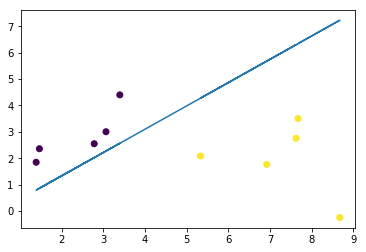

In [16]:
bias = -new_w[0] / new_w[2]
slope = (new_w[0] / new_w[2]) / (-new_w[0] / new_w[1])

plt.scatter(toy_dataset[:,0], toy_dataset[:,1], c=toy_dataset[:,-1])
plt.plot(toy_dataset[:,0], slope*toy_dataset[:,0] + bias)
plt.show()